In [1]:
!pip install "qiskit==0.45.1"
!pip install "qiskit-aer==0.13.3"
!pip install "qiskit-algorithms==0.2.1"
!pip install 'qiskit[visualization]'
!pip install --prefer-binary pyscf
!pip install "qiskit-nature==0.7.1"
!pip install -U --force-reinstall "numpy~=1.24.4"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 47.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which 

In [2]:
import numpy as np

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate, XGate

from qiskit_algorithms import optimizers
from qiskit.primitives import Estimator

from scipy.optimize import minimize

import matplotlib.pyplot as plt

from qiskit import *
from qiskit.visualization import *
from qiskit_aer import Aer

from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper

In [3]:
# Distancia entre los núcleos
dist = 0.725

# Definimos la geometría molecular
geometry = f"H 0.0 0.0 {-dist/2}; H 0.0 0.0 {dist/2}"

# Configuramos el driver PySCF
driver = PySCFDriver(atom=geometry, basis='sto3g')

# Ejecutamos el driver para obtener el problema de la estructura electrónica
es_problem = driver.run()

# Construimos el Hamiltoniano después de la segunda cuantización
hamiltonian = es_problem.second_q_ops()[0]

# Aplicamos las transformaciones de Jordan-Wigner
mapper = JordanWignerMapper()
hamiltonian = mapper.map(hamiltonian)

print(hamiltonian)

matrix = hamiltonian.to_matrix()

# Diagonalizamos el Hamiltoniano para estudiar directamente sus autovalores
eigenvalues, eigenvectors = np.linalg.eigh(matrix)
print(eigenvalues)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.80718366+0.j,  0.17374013+0.j, -0.23047453+0.j,  0.12148839+0.j,
  0.17374013+0.j,  0.16940471+0.j, -0.23047453+0.j,  0.1665822 +0.j,
  0.04509381+0.j,  0.04509381+0.j,  0.04509381+0.j,  0.04509381+0.j,
  0.1665822 +0.j,  0.17510657+0.j,  0.12148839+0.j])
[-1.86712098e+00 -1.26243085e+00 -1.26243085e+00 -1.24188257e+00
 -1.24188257e+00 -1.24188257e+00 -1.16036578e+00 -1.16036578e+00
 -8.81132071e-01 -4.65405263e-01 -4.65405263e-01 -3.40532730e-01
 -3.40532730e-01 -2.10506120e-01  1.38777878e-16  2.26937607e-01]


Iteración 1: Energía = -0.9247632357527954
Iteración 2: Energía = -1.0708918940011636
Iteración 3: Energía = -0.9703835695243872
Iteración 4: Energía = -0.9745756045068005
Iteración 5: Energía = -1.1673008594582164
Iteración 6: Energía = -1.153032530489609
Iteración 7: Energía = -1.0921951238111638
Iteración 8: Energía = -1.2137139783231756
Iteración 9: Energía = -1.3459259287557326
Iteración 10: Energía = -1.197937093234624
Iteración 11: Energía = -1.3032913079152535
Iteración 12: Energía = -1.3618265072159428
Iteración 13: Energía = -1.3578545744934998
Iteración 14: Energía = -1.3080582417741442
Iteración 15: Energía = -1.431610865680273
Iteración 16: Energía = -1.4977950331402246
Iteración 17: Energía = -1.4782519921633397
Iteración 18: Energía = -1.5057816648221274
Iteración 19: Energía = -1.5056026050743643
Iteración 20: Energía = -1.3075238912132814
Iteración 21: Energía = -1.6887661985735807
Iteración 22: Energía = -1.4691663860734896
Iteración 23: Energía = -1.6092893371548693


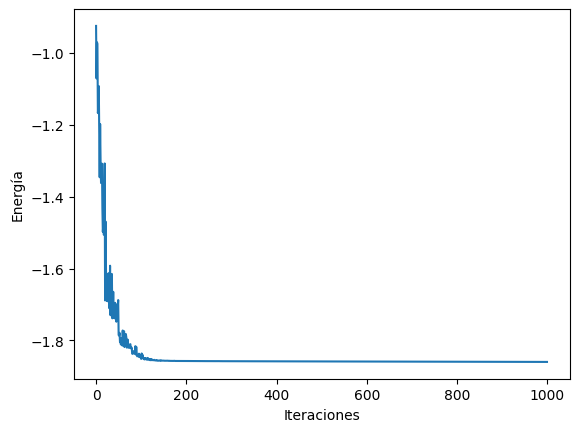

In [4]:
# Simulador local
simulator = Aer.get_backend('qasm_simulator')

# Ansatz de 4 qubits
theta = Parameter("θ")
ansatz = NLocal(
    num_qubits=4,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],  # Keep rotation blocks
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [1, 2, 3]],  # Define entanglement pattern
    reps=2,
    insert_barriers=True,
)

num_params = ansatz.num_parameters

# Inicialización del parámetro
x0 = 2 * np.pi * np.random.random(num_params)

# Diccionario para almacenar la evolución del costo
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

# Función de coste
def cost_func(params, ansatz, hamiltonian, estimator):
    job = estimator.run([ansatz], [hamiltonian], [params])
    result = job.result()
    energy = result.values[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)

    print(f"Iteración {cost_history_dict['iters']}: Energía = {energy}")

    return energy

# Creamos el estimador para el simulador
backend=simulator
estimator = Estimator()

# Ejecutamos la optimización
res = minimize(
    cost_func,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="COBYLA",
)

# Resultado final
print("Parámetros óptimos:", res.x)
print("Energía mínima encontrada:", res.fun)

# Graficar evolución del costo
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iteraciones")
ax.set_ylabel("Energía")
plt.show()

In [5]:
nuclear_repulsion = es_problem.nuclear_repulsion_energy # 1/R
print(f"Energía nuclear: {nuclear_repulsion}")
energy = res.fun + nuclear_repulsion
print(f"Energía total: {energy}")

Energía nuclear: 0.7298996012689656
Energía total: -1.1299422631769518


/usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


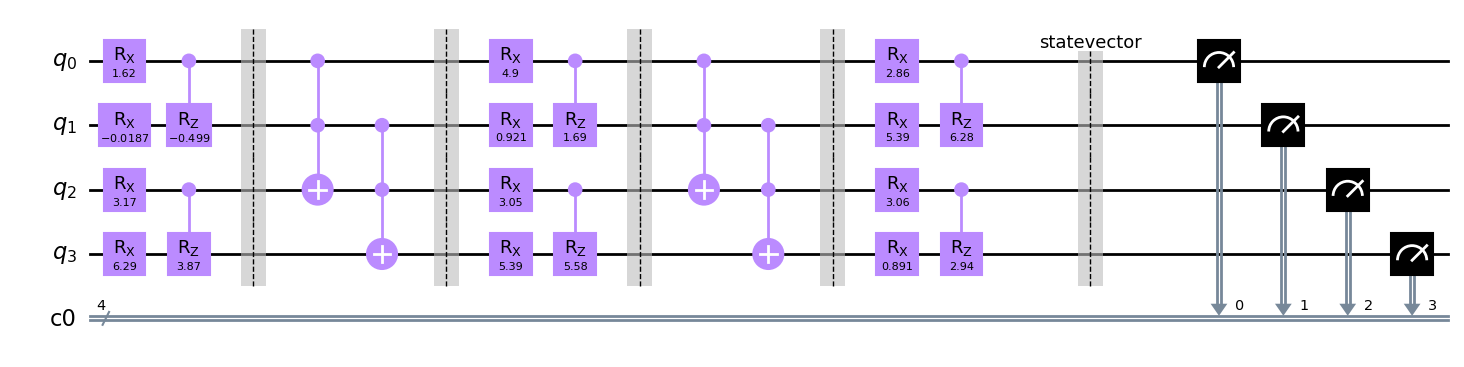

In [6]:
# Estado cuántico

qc_bound = ansatz.assign_parameters({list(ansatz.parameters)[i]: res.x[i] for i in range(len(res.x))}) # Asignamos los parámetros al circuito

c_reg = ClassicalRegister(ansatz.num_qubits) # Añadimos un bit clásico a qc_bound
qc_bound.add_register(c_reg)

qc_bound.save_statevector() # Guardamos el estado antes de la medida

qc_bound.measure(range(4),range(4)) # Medimos

qc_bound.decompose().draw("mpl") # Dibujamos

Statevector([-6.66783954e-04-0.00171409j, -1.08108919e-03-0.00187319j,
              5.78594483e-04+0.00269022j,  4.39136957e-03+0.01323549j,
              3.13482814e-04+0.00025712j,  9.84335805e-01-0.14457023j,
             -5.91778141e-02+0.01259324j, -4.33462273e-04-0.00564009j,
             -4.39410927e-03-0.03320819j,  1.45469419e-02-0.0057671j ,
             -6.89439724e-02+0.00962852j,  2.17851610e-03-0.00616001j,
              1.69137280e-03+0.00087517j, -1.57782350e-04-0.00032152j,
              6.98642061e-05+0.0008062j , -2.12780656e-03-0.00387783j],
            dims=(2, 2, 2, 2))


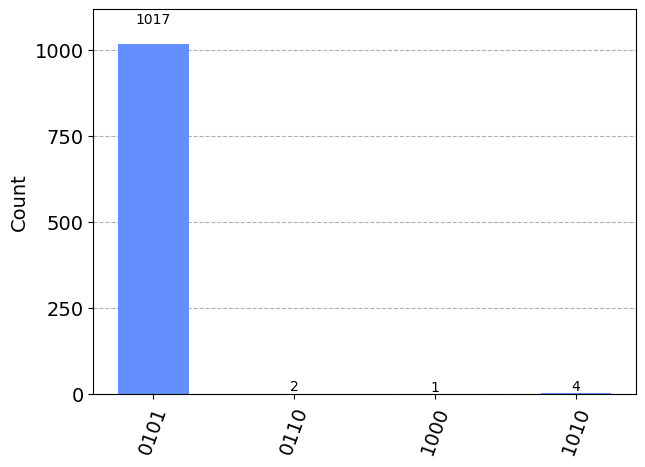

In [7]:
# Simulamos

sim = Aer.get_backend('qasm_simulator')
my_circuit = transpile(qc_bound, sim)
job = sim.run(my_circuit)
result = job.result()

sv = result.get_statevector()
print(sv)

counts = result.get_counts()
plot_histogram(counts)

Calculando para distancia 0.250 Å
Energía en 0.250 Å: -0.305176 Ha
Calculando para distancia 0.406 Å
Energía en 0.406 Å: -0.916649 Ha
Calculando para distancia 0.562 Å
Energía en 0.562 Å: -1.085710 Ha
Calculando para distancia 0.719 Å
Energía en 0.719 Å: -1.117457 Ha
Calculando para distancia 0.875 Å
Energía en 0.875 Å: -1.114487 Ha
Calculando para distancia 1.031 Å
Energía en 1.031 Å: -1.086937 Ha
Calculando para distancia 1.188 Å
Energía en 1.188 Å: -1.051391 Ha
Calculando para distancia 1.344 Å
Energía en 1.344 Å: -1.005468 Ha
Calculando para distancia 1.500 Å
Energía en 1.500 Å: -0.961837 Ha
Calculando para distancia 1.656 Å
Energía en 1.656 Å: -0.959552 Ha
Calculando para distancia 1.812 Å
Energía en 1.812 Å: -0.917229 Ha
Calculando para distancia 1.969 Å
Energía en 1.969 Å: -0.875946 Ha
Calculando para distancia 2.125 Å
Energía en 2.125 Å: -0.927493 Ha
Calculando para distancia 2.281 Å
Energía en 2.281 Å: -0.934406 Ha
Calculando para distancia 2.438 Å
Energía en 2.438 Å: -0.93125

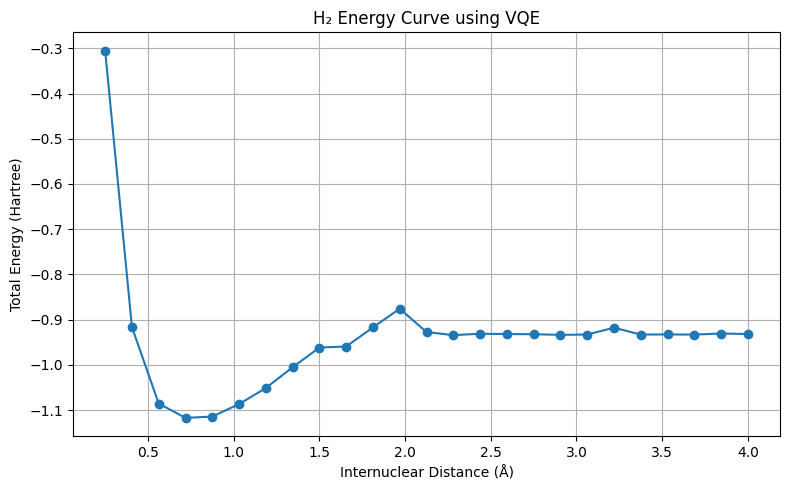

In [9]:
# Range of distances in Angstroms
distances = np.linspace(0.25, 4, 25)
energies = []

for dist in distances:
    print(f"Calculando para distancia {dist:.3f} Å")

    # Geometry string with correct distance
    geometry = f"H 0.0 0.0 {-dist/2}; H 0.0 0.0 {dist/2}"

    # Set up the driver
    driver = PySCFDriver(atom=geometry, basis='sto3g')
    es_problem = driver.run()

    # Build Hamiltonian
    hamiltonian = es_problem.second_q_ops()[0]
    mapper = JordanWignerMapper()
    hamiltonian = mapper.map(hamiltonian)

    # Define ansatz
    theta = Parameter("θ")
    ansatz = NLocal(
        num_qubits=4,
        rotation_blocks=[RXGate(theta), CRZGate(theta)],
        entanglement_blocks=CCXGate(),
        entanglement=[[0, 1, 2], [1, 2, 3]],
        reps=2,
        insert_barriers=True,
    )
    for qubit in [0, 2]:
        ansatz.add_layer(XGate(), [qubit])

    num_params = ansatz.num_parameters
    x0 = 2 * np.pi * np.random.random(num_params)

    # Reset cost tracking
    cost_history_dict = {"prev_vector": None, "iters": 0, "cost_history": []}

    # Cost function
    def cost_func(params, ansatz, hamiltonian, estimator):
        job = estimator.run([ansatz], [hamiltonian], [params])
        result = job.result()
        energy = result.values[0]
        cost_history_dict["iters"] += 1
        cost_history_dict["prev_vector"] = params
        cost_history_dict["cost_history"].append(energy)
        return energy

    # Estimator
    estimator = Estimator()

    # Optimize
    res = minimize(
        cost_func,
        x0,
        args=(ansatz, hamiltonian, estimator),
        method="COBYLA",
    )

    # Total energy (electronic + nuclear repulsion)
    nuclear_repulsion = es_problem.nuclear_repulsion_energy
    total_energy = res.fun + nuclear_repulsion
    energies.append(total_energy)

    print(f"Energía en {dist:.3f} Å: {total_energy:.6f} Ha")

# Plot the potential energy curve
plt.figure(figsize=(8, 5))
plt.plot(distances, energies, marker='o', linestyle='-')
plt.title("H₂ Energy Curve using VQE")
plt.xlabel("Internuclear Distance (Å)")
plt.ylabel("Total Energy (Hartree)")
plt.grid(True)
plt.tight_layout()
plt.show()
